In [1]:
# Install gammapy in Google colab
# Afterwards press 'Restart Runtime'
!pip install gammapy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# We will use gammapy v1.0
# Check that you have correct version
import gammapy
gammapy.__version__

'1.0'

In [3]:
# CTA IRFs are officially downloaded from the following link
# The zip contains many IRFs for many different configurations,
# check it out if you are interested to see different ones

# https://zenodo.org/record/5499840/files/cta-prod5-zenodo-fitsonly-v0.1.zip?download=1

# You can find the ones I'll be using on my github
# There are 3 files for the same configurations but different observation times
# Upload them to colab:
# On the left click the folder, then the file with the arrow
# The following command should show them:

In [4]:
ls

ebl_dominguez11.fits
ebl_franceschini.fits
frd_abs.fits
gammapy-Counts0.pdf
gammapy-SimulatedSpectrum0.pdf
gammapy-SimulatedSpectrum1.pdf
matplotlibrc
Prod5-South-20deg-AverageAz-14MSTs37SSTs.180000s-v0.1.fits.gz
Prod5-South-20deg-AverageAz-14MSTs37SSTs.18000s-v0.1.fits.gz
Prod5-South-20deg-AverageAz-14MSTs37SSTs.1800s-v0.1.fits.gz
sample_data/


In [5]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
import matplotlib.pyplot as plt

In [6]:
from gammapy.modeling.models import PowerLawSpectralModel, SkyModel, EBLAbsorptionNormSpectralModel
from gammapy.maps import MapAxis, RegionGeom
from gammapy.data import Observation, observatory_locations
from gammapy.datasets import SpectrumDatasetOnOff, SpectrumDataset, Datasets, FluxPointsDataset
from gammapy.makers import SpectrumDatasetMaker
from gammapy.estimators import FluxPointsEstimator
from gammapy.irf import load_cta_irfs

In [7]:
irfs = {'irf':[], 'name':[]}

irfs['name'].append('0.5h')
irfs['irf'].append(load_cta_irfs('Prod5-South-20deg-AverageAz-14MSTs37SSTs.1800s-v0.1.fits.gz'))

irfs['name'].append('5h')
irfs['irf'].append(load_cta_irfs('Prod5-South-20deg-AverageAz-14MSTs37SSTs.18000s-v0.1.fits.gz'))

irfs['name'].append('50h')
irfs['irf'].append(load_cta_irfs('Prod5-South-20deg-AverageAz-14MSTs37SSTs.180000s-v0.1.fits.gz'))

In [8]:
name = 'CTA Simulation'

# Choose arbitrary pointing for this simulation
pointing = SkyCoord(0, 0, unit='deg', frame='galactic')

# Related to angular resolution and extension
# (Extragalactic sources are point sources)
on_region_radius = Angle('0.11 deg')

# Define gamma-ray source spectrum
# Note: Something seems wrong / inconsistent with the spectrum normalisation
# - much higher than in previous versions - in the new (finally v1!!) version
# I adapted the amplitude accordingly
spectral_model = PowerLawSpectralModel(
    index=2.4,
    amplitude="1e-9 cm-2 s-1 GeV-1",
    reference=10 * u.GeV,
)

# Define gamma-ray source spectrum
spectral_model *= EBLAbsorptionNormSpectralModel.read(
    'ebl_dominguez11.fits', 
    redshift=0.4
)

print(spectral_model)
model = SkyModel(spectral_model=spectral_model, name=name)

CompoundSpectralModel
    Component 1 : PowerLawSpectralModel

  type      name     value         unit      ... max frozen is_norm link
-------- --------- ---------- -------------- ... --- ------ ------- ----
spectral     index 2.4000e+00                ... nan  False   False     
spectral amplitude 1.0000e-09 cm-2 GeV-1 s-1 ... nan  False    True     
spectral reference 1.0000e+01            GeV ... nan   True   False     
    Component 2 : EBLAbsorptionNormSpectralModel

  type      name      value    unit   error   min max frozen is_norm link
-------- ---------- ---------- ---- --------- --- --- ------ ------- ----
spectral alpha_norm 1.0000e+00      0.000e+00 nan nan   True   False     
spectral   redshift 4.0000e-01      0.000e+00 nan nan   True   False     
    Operator : mul



In [9]:
# Define simulation parameters

# Choose observation time you want to simulate
# The IRF you loaded before should be in the same range (seconds / minutes / hours)
# If not, reload different IRF
livetime = 0.5 * u.h

# This is how far away from our source we point. 
# Performance is dependent on this.
# The larger, the more certain the background estimate
# Should not be larger than camera FoV
offset = 1 * u.deg

# Reconstructed energy axis
# Standard in CTA is 5 bins per decade (related to energy resolution)
energy_axis = MapAxis.from_edges(
    np.logspace(-1, 3, 21), unit="TeV", name="energy", interp="log"
)

# True energy axis
# Should always cover larger range as reconstructed axis on both sides
# Should also have finer binning, 
# for example to properly capture steep changes in effective area
energy_axis_true = MapAxis.from_edges(
    np.logspace(-1.5, 4.0, 101), unit="TeV", name="energy_true", interp="log"
)

center = pointing.directional_offset_by(
    position_angle=0*u.deg, separation=offset
)
on_region = CircleSkyRegion(center=center, radius=on_region_radius)

# New Section

In [10]:
# Make the SpectrumDataset
geom = RegionGeom.create(region=on_region, axes=[energy_axis])

dataset_empty = SpectrumDataset.create(
    geom=geom, energy_axis_true=energy_axis_true, #name="obs-0"
)
maker = SpectrumDatasetMaker(selection=["exposure", "edisp", "background"])

In [11]:
fpe = FluxPointsEstimator(energy_edges=energy_axis.edges, 
                          selection_optional='all')

In [12]:
datasets = Datasets()

location = observatory_locations["cta_south"]
obs = Observation.create(
        pointing=pointing,
        livetime=livetime,
        irfs=irfs['irf'][0],
        location=location,
)
    
dataset = maker.run(dataset_empty, obs)

# Set the model on the dataset, and fake
dataset.models = model
dataset.fake(random_state=42)
print(dataset)
    
dataset_on_off = SpectrumDatasetOnOff.from_spectrum_dataset(
dataset=dataset, acceptance=1, acceptance_off=5, name=irfs['name'][0]
)
dataset_on_off.fake(random_state=42, npred_background=dataset.npred_background())
print(dataset_on_off)

# Handy for loops when simulating multiple datasets, e.g. with different observation times
datasets.append(dataset_on_off)

SpectrumDataset
---------------

  Name                            : mXhFBjV3 

  Total counts                    : 1010 
  Total background counts         : 162.27
  Total excess counts             : 847.73

  Predicted counts                : 1018.75
  Predicted background counts     : 162.27
  Predicted excess counts         : 856.48

  Exposure min                    : 1.77e+07 m2 s
  Exposure max                    : 8.09e+09 m2 s

  Number of total bins            : 20 
  Number of fit bins              : 20 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -9505.65

  Number of models                : 1 
  Number of parameters            : 5
  Number of free parameters       : 2

  Component 0: SkyModel
  
    Name                      : CTA Simulation
    Datasets names            : None
    Spectral model type       : CompoundSpectralModel
    Spatial  model type       : 
    Temporal model type       : 
    Parameters:
      index                 

In [13]:
# Append a dataset with 50h observation time
# Note the change in IRF
obs = Observation.create(
        pointing=pointing,
        livetime=50*u.h,
        irfs=irfs['irf'][2],
        location=location,
)
    
dataset = maker.run(dataset_empty, obs)
dataset.models = model
dataset.fake(random_state=42)
    
dataset_on_off = SpectrumDatasetOnOff.from_spectrum_dataset(
dataset=dataset, acceptance=1, acceptance_off=5, name=irfs['name'][2]
)
dataset_on_off.fake(random_state=42, npred_background=dataset.npred_background())
datasets.append(dataset_on_off)

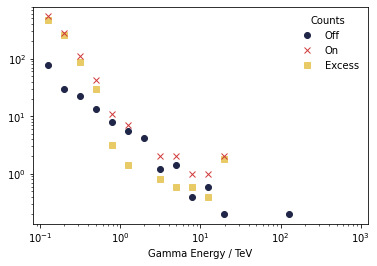

In [14]:
plt.plot(energy_axis.center, datasets[0].counts_off.data[:,:,0]/5, 'o', label='Off')
plt.plot(energy_axis.center, datasets[0].counts.data[:,:,0], 'x', label='On', lw=3, zorder=100)
plt.plot(energy_axis.center, datasets[0].excess.data[:,:,0], 's', label='Excess')

plt.legend(title='Counts')

plt.xscale('log')
plt.yscale('log')

plt.xlabel(f'Gamma Energy / {energy_axis.unit}')

plt.savefig(f'gammapy-Counts0.pdf');

In [15]:
datasets.info_table()

name,counts,excess,sqrt_ts,background,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,counts_off,acceptance,acceptance_off,alpha
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,,,,,
str4,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str5,float64,int64,float64,float64,float64
0.5h,999,833.5999755859375,36.96413709579639,165.39999389648438,304.3333371124334,304.3333371124334,nan,17698366.0,8090206720.0,1799.9999999999984,1799.9999999999984,0.5550000000000005,0.09188888549804695,0.4631110975477435,20,20,wstat,1488.5802642738531,827,20.0,100.00000762939453,0.19999998807907104
50h,64445,57206.8,335.6570181182216,7238.2,64574.67987093666,7234.754990871679,57339.92488006498,373461093.2592277,599924825271.8473,180000.0,180000.0,0.3580277777777778,0.04021222222222222,0.3178155555555556,20,20,wstat,14.883915075528805,36191,20.0,100.00000000000001,0.19999999999999998


In [16]:
flux_points_datasets = Datasets()

for d in datasets:
    flux_points = fpe.run(datasets=[d])
    flux_points_datasets.append(
        FluxPointsDataset(data=flux_points, models=model, name=d.name))

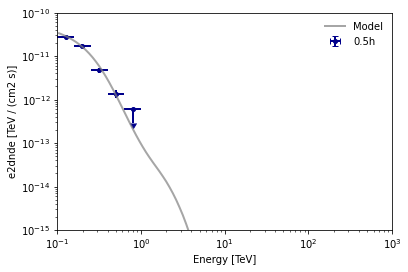

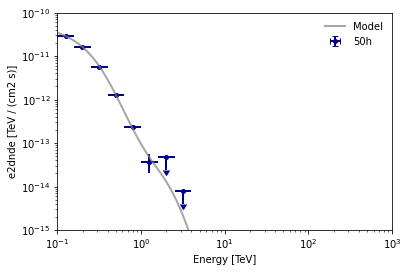

In [17]:
ax = plt.subplot()
ax.yaxis.set_units(u.Unit("TeV cm-2 s-1"))

kwargs = {"ax": ax, "sed_type": "e2dnde"}

for i, d in enumerate(flux_points_datasets):
    ax = plt.subplot()
    ax.yaxis.set_units(u.Unit("TeV cm-2 s-1"))
    kwargs = {"ax": ax, "sed_type": "e2dnde"}
        
    d.plot_spectrum(kwargs_fp = {'label': d.name, 'color':'darkblue'}, 
                    kwargs_model = {'label':'Model', 'color':'gray', 'alpha': 0.7})

    ax.legend(loc='upper right')
    ax.set_ylim(1e-15, 1e-10)
    plt.savefig(f'gammapy-SimulatedSpectrum{i}.pdf')
    plt.show()